In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as disp
from math import log10, floor

import numpy as np
import plotly.express as px

# Load cohort salary data
df = pd.read_csv("cohort_salaries.csv")

# Convert salary columns to numeric (removing $ and commas)
for col in df.columns[1:]:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Quick check
print(df.head())

# --- Helper: 3 sig figs (+ $ for money-ish cols) ---
def _sig_digits_decimals(x, sig=3):
    x = float(x)
    if x == 0 or np.isnan(x) or np.isinf(x):
        return 0
    return max(0, sig - int(floor(log10(abs(x)))) - 1)

def _fmt_num_sig3(x):
    if pd.isna(x):
        return ""
    d = _sig_digits_decimals(x, 3)
    return f"{x:,.{d}f}"

def _fmt_money_sig3(x):
    if pd.isna(x):
        return ""
    d = _sig_digits_decimals(x, 3)
    return f"${x:,.{d}f}"

def styled_display(df: pd.DataFrame, caption: str = ""):
    """Render df with 3 sig figs; add $ to money-ish columns by name. Leaves df untouched."""
    num_cols = df.select_dtypes(include=[np.number]).columns
    money_keywords = ("salary", "total", "target", "school", "gap", "weighted", "load", "amount", "$")
    money_cols = [c for c in num_cols if any(k in c.lower() for k in money_keywords)]
    fmt_map = {c: _fmt_money_sig3 for c in money_cols}
    for c in num_cols:
        if c not in money_cols:
            fmt_map[c] = _fmt_num_sig3
    styler = df.style.format(fmt_map)
    if caption:
        styler = styler.set_caption(caption)
    disp.display(styler)

      Group  0-5 yrs  6-10 yrs  11-15 yrs  16-20 yrs  21-25 yrs  26-30 yrs  \
0  ST MARYS  54302.0   67763.0    69931.0    70864.0    76288.0    84796.0   
1  National  59679.0   69735.0    72868.0    75020.0    80206.0    81598.0   
2  Regional  63918.0   70156.0    73061.0    76493.0    80735.0    83770.0   
3     State  54900.0   60077.0    65472.0    71341.0    76802.0    83770.0   
4     Local  61530.0   72696.0    79456.0    86476.0    92560.0    95035.0   

   31-35 yrs   36+ yrs  
0    79276.0   92356.0  
1    87369.0   92335.0  
2    95009.0   99417.0  
3    88338.0   95059.0  
4   101666.0  103719.0  


In [192]:
# Melt into long-form for plotting
df_long = df.melt(id_vars=df.columns[0], 
                  var_name="Experience Band", 
                  value_name="Salary")

# Rename first column for clarity
df_long = df_long.rename(columns={df.columns[0]: "Group"})

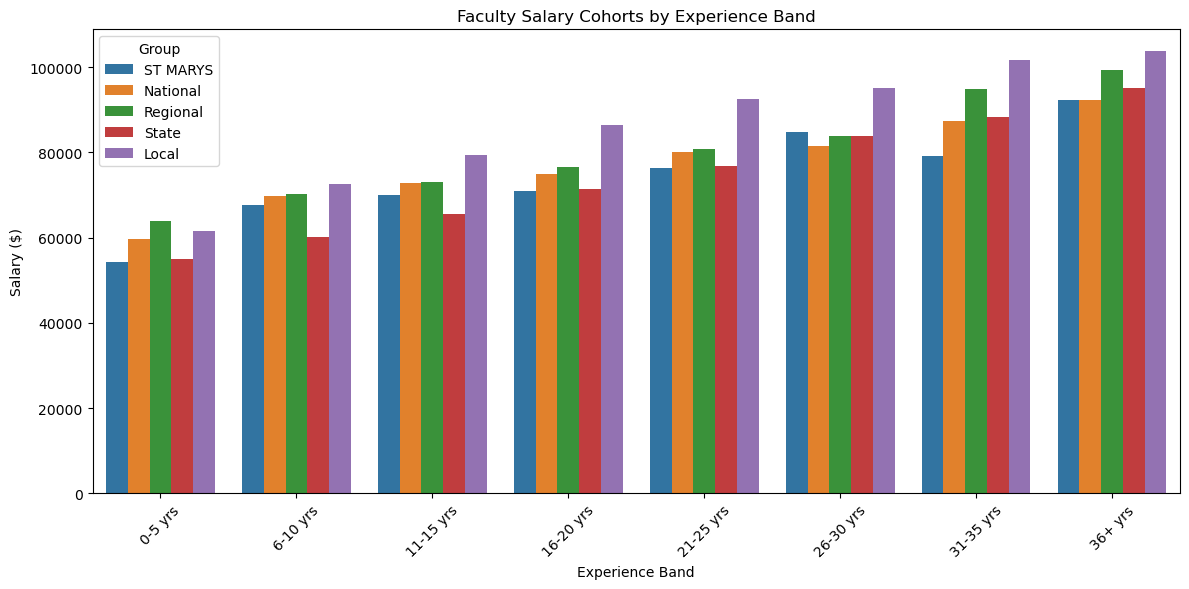

In [193]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_long, x="Experience Band", y="Salary", hue="Group")

plt.title("Faculty Salary Cohorts by Experience Band")
plt.xlabel("Experience Band")
plt.ylabel("Salary ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [194]:
# --------------------------------------
# 1) Load inputs (same notebook)
# --------------------------------------
# ----- Load files -----
cohorts = pd.read_csv("cohort_salaries.csv")
dist = pd.read_csv("distribution.csv")

# Strip whitespace from headers and band names
cohorts.columns = cohorts.columns.str.strip()
dist["Band"] = dist["Band"].str.strip()

# Find the label column robustly (fallback to the first column)
label_candidates = {"group", "school", "cohort", "name"}
label_col = None
for c in cohorts.columns:
    if c.strip().lower() in label_candidates:
        label_col = c
        break
if label_col is None:
    label_col = cohorts.columns[0]  # fallback: first column is the label column

# Band columns = everything except the label column
band_cols = [c for c in cohorts.columns if c != label_col]

# Helper to coerce dollars -> float
def _to_float(s):
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float)):
        return float(s)
    s = str(s).strip().replace("$", "").replace(",", "")
    try:
        return float(s)
    except ValueError:
        return np.nan  # leave anything unexpected as NaN

# Convert only the band columns to numeric
for c in band_cols:
    cohorts[c] = cohorts[c].map(_to_float)

# Make sure distribution bands match the cohort band columns and preserve order
band_order = [b for b in band_cols if b in dist["Band"].tolist()]
dist = dist.set_index("Band").reindex(band_order).fillna(0).reset_index()

In [ ]:
# --------------------------------------
# 2) Simulator (with No-Change + Investment)
# --------------------------------------
def simulate_salary_path(
    cohort_df: pd.DataFrame,
    dist_df: pd.DataFrame,
    target_group: str = "Local",
    school_group: str = "ST MARYS",
    target_pct: float = 0.90,
    horizon: int = 2,
    cohort_growth: float = 0.03
):
    lbl = "Group"
    if 'label_col' in globals() and label_col in cohort_df.columns:
        lbl = label_col

    school_row = cohort_df.loc[cohort_df[lbl] == school_group, band_order]
    target_row = cohort_df.loc[cohort_df[lbl] == target_group, band_order]
    if school_row.empty or target_row.empty:
        raise ValueError(f"Could not find school_group or target_group in '{lbl}' column.")

    school_now = school_row.iloc[0].astype(float).values
    target_now = target_row.iloc[0].astype(float).values
    weights = dist_df.set_index("Band").loc[band_order, "Count"].astype(float).values

    per_band_records = []
    total_records = []
    cumulative_investment = 0.0

    for year in range(horizon + 1):
        growth_factor = (1.0 + cohort_growth) ** year

        # (1) cohort target & no-change
        target_band = target_now * growth_factor * target_pct
        no_change_band = school_now * growth_factor

        # ✅ floor the target at the no-change path
        target_band = np.maximum(target_band, no_change_band)

        # (2) planned school path (linear close)
        closeness = year / horizon if horizon > 0 else 1.0
        school_band = school_now + (target_band - school_now) * closeness

        # 🔧 also floor the school path at no-change (no backward movement)
        school_band = np.maximum(school_band, no_change_band)

        # per-band rows
        for b, s_val, t_val, nc_val, w in zip(band_order, school_band, target_band, no_change_band, weights):
            per_band_records.append({
                "Year": year,
                "Band": b,
                "School": s_val,
                "Target": t_val,
                "No-Change": nc_val,
                "Gap": t_val - s_val,
                "Weighted School": s_val * w,
                "Weighted Target": t_val * w,
                "Weighted No-Change": nc_val * w,
                "Weighted Gap": (t_val - s_val) * w,
                "Weighted Investment": (s_val - nc_val) * w
            })

        # totals
        school_total     = np.dot(school_band, weights)
        target_total     = np.dot(target_band, weights)
        no_change_total  = np.dot(no_change_band, weights)
        gap_total        = target_total - school_total
        investment_total = school_total - no_change_total  # >0 = spend above no-change
        cumulative_investment += investment_total

        total_records.append({
            "Year": year,
            "School Total": school_total,
            "Target Total": target_total,
            "No-Change Total": no_change_total,
            "Gap Total": gap_total,
            "Investment Total": investment_total,
            "Cumulative Investment": cumulative_investment
        })

    per_band = pd.DataFrame(per_band_records)
    totals   = pd.DataFrame(total_records)
    return per_band, totals

In [212]:
# --------------------------------------
# 3) Run a baseline scenario (edit as needed)
# --------------------------------------
per_band, totals = simulate_salary_path(
    cohorts, dist,
    target_group="Local",      # <- change to "Regional"/"National" etc.
    school_group="ST MARYS",   # <- your row name in the cohort file
    target_pct=1.00,           # 1.00 = cohort median; try 1.10 for 110% of median
    horizon=5,
    cohort_growth=0.05         # 3% growth in cohort medians each year
)

# Quick peek (formatted)
styled_display(totals.head(10), "Totals (first rows)")
styled_display(per_band.head(15), "Per-band (first rows)")

,Year,School Total,Target Total,No-Change Total,Gap Total,Investment Total,Cumulative Investment
0,0,"$5,484,413","$6,297,704","$5,484,413","$813,291",$0,0
1,1.00,"$5,771,358","$6,612,589","$5,758,634","$841,231","$12,724","12,724"
2,2.00,"$6,114,380","$6,943,219","$6,046,565","$828,839","$67,815","80,539"
3,3.00,"$6,584,069","$7,290,380","$6,348,894","$706,310","$235,176","315,715"
4,4.00,"$7,220,801","$7,654,899","$6,666,338","$434,097","$554,463","870,178"
5,5.00,"$8,037,644","$8,037,644","$6,999,655",$0,"$1,037,988","1,908,166"


,Year,Band,School,Target,No-Change,Gap,Weighted School,Weighted Target,Weighted No-Change,Weighted Gap,Weighted Investment
0,0,0-5 yrs,"$54,302","$61,530","54,302","$7,228","$543,020","$615,300","$543,020","$72,280",$0
1,0,6-10 yrs,"$67,763","$72,696","67,763","$4,933","$1,287,497","$1,381,224","$1,287,497","$93,727",$0
2,0,11-15 yrs,"$69,931","$79,456","69,931","$9,525","$1,118,896","$1,271,296","$1,118,896","$152,400",$0
3,0,16-20 yrs,"$70,864","$86,476","70,864","$15,612","$1,133,824","$1,383,616","$1,133,824","$249,792",$0
4,0,21-25 yrs,"$76,288","$92,560","76,288","$16,272","$534,016","$647,920","$534,016","$113,904",$0
5,0,26-30 yrs,"$84,796","$95,035","84,796","$10,239","$339,184","$380,140","$339,184","$40,956",$0
6,0,31-35 yrs,"$79,276","$101,666","79,276","$22,390","$158,552","$203,332","$158,552","$44,780",$0
7,0,36+ yrs,"$92,356","$103,719","92,356","$11,363","$369,424","$414,876","$369,424","$45,452",$0
8,1.00,0-5 yrs,"$57,017","$64,606","57,017","$7,589","$570,171","$646,065","$570,171","$75,894",$0
9,1.00,6-10 yrs,"$71,151","$76,331","71,151","$5,180","$1,351,872","$1,450,285","$1,351,872","$98,413",$0


In [213]:
# --------------------------------------
# 4) Visuals (now with No-Change path)
# --------------------------------------

# (A) Total salary load over time (School vs Target vs No-Change)
totals_long = totals.melt(
    id_vars="Year",
    value_vars=["School Total", "Target Total", "No-Change Total"],
    var_name="Series",
    value_name="Salary Load ($)"
)

fig1 = px.line(
    totals_long,
    x="Year", y="Salary Load ($)", color="Series",
    markers=True,
    title="Total Salary Load Trajectory: School vs Target vs No-Change"
)
fig1.update_yaxes(tickprefix="$", separatethousands=True)
fig1.update_traces(hovertemplate="%{x}: %{y:$,.0f}")
fig1.show()

# # (B) Per-band trajectories (School vs Target vs No-Change)
# per_band_long = per_band.melt(
#     id_vars=["Year", "Band"],
#     value_vars=["School", "Target", "No-Change"],
#     var_name="Series",
#     value_name="Salary ($)"
# )

# fig2 = px.line(
#     per_band_long,
#     x="Year", y="Salary ($)", color="Series", facet_row="Band",
#     markers=True,
#     title="Per-Band Salary Trajectories: School vs Target vs No-Change",
#     height=max(400, 150 * len(band_order))
# )
# fig2.update_yaxes(tickprefix="$", separatethousands=True)
# fig2.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))  # cleaner facet labels
# fig2.update_traces(hovertemplate="%{x}: %{y:$,.0f}")
# fig2.show()

In [198]:
# (C) Optional: Yearly & Cumulative Investment
fig3 = px.bar(
    totals,
    x="Year", y="Investment Total",
    title="Yearly Investment vs No-Change",
    labels={"Investment Total": "Investment ($)"}
)
fig3.update_yaxes(tickprefix="$", separatethousands=True)
fig3.update_traces(hovertemplate="Year %{x}<br>Investment: %{y:$,.0f}")
fig3.show()

#Stepped simulator!#

In [214]:
def simulate_salary_path_steps(
    cohort_df: pd.DataFrame,
    dist_df: pd.DataFrame,
    band_order: list[str],
    target_group: str = "Local",
    school_group: str = "ST MARYS",
    target_steps: list[float] = None,   # e.g., [0.85, 0.92, 0.97, 1.00]
    cohort_growth: float = 0.03,        # annual growth of cohort medians
    hit_steps: bool = True              # if False, interpolate toward final target instead
):
    """
    Step-driven salary simulator.

    - Step Target (per year) = cohort_median(year) * step_pct
    - Final Target (every year) = cohort_median(year) * steps[-1]
    - School path:
        if hit_steps=True: School = max(Step Target, No-Change)
        else:              School = max(linear path to Final Target, No-Change)

    Returns:
      per_band: Year, Band, School, Step Target, Final Target, No-Change, Gap to Final, Weighted*
      totals:   Year, School Total, Step Target Total, Final Target Total, No-Change Total,
                Gap to Final Total, Investment Total, Cumulative Investment
    """
    if not target_steps:
        raise ValueError("Provide a non-empty list for 'target_steps' (e.g., [0.85, 0.92, 0.97, 1.00]).")

    # Find the label column
    label_candidates = {"group", "school", "cohort", "name"}
    lbl = next((c for c in cohort_df.columns if c.strip().lower() in label_candidates), cohort_df.columns[0])

    # Current medians by band (year 0)
    school_row = cohort_df.loc[cohort_df[lbl] == school_group, band_order]
    target_row = cohort_df.loc[cohort_df[lbl] == target_group, band_order]
    if school_row.empty or target_row.empty:
        raise ValueError(f"Could not find school_group='{school_group}' or target_group='{target_group}' in '{lbl}'.")

    school_now = school_row.iloc[0].astype(float).values
    target_now = target_row.iloc[0].astype(float).values
    weights = dist_df.set_index("Band").loc[band_order, "Count"].astype(float).values

    per_band_records, total_records = [], []
    cumulative_investment = 0.0
    n_years = len(target_steps)

    for year, step_pct in enumerate(target_steps):
        growth_factor = (1.0 + cohort_growth) ** year

        # Targets for this year
        step_target_band  = target_now * growth_factor * float(step_pct)           # step plan for this year
        final_target_band = target_now * growth_factor * float(target_steps[-1])   # end-state target, each year
        no_change_band    = school_now * growth_factor

        if hit_steps:
            # Hit the step exactly (but don't go below no-change)
            school_band = np.maximum(step_target_band, no_change_band)
        else:
            # Smooth linear path from current to final target over all years
            closeness   = year / (n_years - 1) if n_years > 1 else 1.0
            planned     = school_now + (final_target_band - school_now) * closeness
            school_band = np.maximum(planned, no_change_band)

        # Per-band rows
        for b, s_val, st_val, ft_val, nc_val, w in zip(
            band_order, school_band, step_target_band, final_target_band, no_change_band, weights
        ):
            per_band_records.append({
                "Year": year,
                "Band": b,
                "School": s_val,
                "Step Target": st_val,
                "Final Target": ft_val,
                "No-Change": nc_val,
                "Gap to Final": ft_val - s_val,
                "Weighted School": s_val * w,
                "Weighted Step Target": st_val * w,
                "Weighted Final Target": ft_val * w,
                "Weighted No-Change": nc_val * w,
                "Weighted Gap to Final": (ft_val - s_val) * w,
                "Weighted Investment": (s_val - nc_val) * w  # spend above no-change
            })

        # Totals
        school_total      = np.dot(school_band, weights)
        step_target_total = np.dot(step_target_band, weights)
        final_target_total= np.dot(final_target_band, weights)
        no_change_total   = np.dot(no_change_band,  weights)
        gap_to_final_total= final_target_total - school_total
        investment_total  = school_total - no_change_total
        cumulative_investment += investment_total

        total_records.append({
            "Year": year,
            "School Total": school_total,
            "Step Target Total": step_target_total,
            "Final Target Total": final_target_total,
            "No-Change Total": no_change_total,
            "Gap to Final Total": gap_to_final_total,
            "Investment Total": investment_total,
            "Cumulative Investment": cumulative_investment
        })

    return pd.DataFrame(per_band_records), pd.DataFrame(total_records)

In [200]:
# Example steps (year 0..3)
steps = [0.85, 0.92, 0.97, 1.00]# Pretty tables

per_band_steps, totals_steps = simulate_salary_path_steps(
    cohort_df=cohorts,
    dist_df=dist,
    band_order=band_order,
    target_group="Local",
    school_group="ST MARYS",
    target_steps=[0.90, 0.93, 0.95, .97, .99, 1],   # 4-year plan
    cohort_growth=0.05,
    hit_steps=True
)
styled_display(totals_steps, "Totals (stepped plan)")
styled_display(per_band_steps.head(15), "Per-band (first rows, stepped plan)")

# Show only the three lines you care about
plot_cols = ["School Total", "Final Target Total", "No-Change Total"]
totals_long = totals_steps.melt(id_vars="Year", value_vars=plot_cols,
                                var_name="Series", value_name="Salary Load ($)")

fig = px.scatter(
    totals_long, x="Year", y="Salary Load ($)", color="Series",
    title="Salary Load: Stepped Plan vs Final Target vs No-Change"
)
fig.update_yaxes(tickprefix="$", separatethousands=True)
fig.show()

,Year,School Total,Step Target Total,Final Target Total,No-Change Total,Gap to Final Total,Investment Total,Cumulative Investment
0,0,"$5,712,329","$5,667,934","$6,297,704","$5,484,413","$585,375","$227,916","227,916"
1,1.00,"$6,152,815","$6,149,708","$6,612,589","$5,758,634","$459,775","$394,181","622,097"
2,2.00,"$6,596,058","$6,596,058","$6,943,219","$6,046,565","$347,161","$549,492","1,171,589"
3,3.00,"$7,071,668","$7,071,668","$7,290,380","$6,348,894","$218,711","$722,775","1,894,364"
4,4.00,"$7,578,350","$7,578,350","$7,654,899","$6,666,338","$76,549","$912,011","2,806,375"
5,5.00,"$8,037,644","$8,037,644","$8,037,644","$6,999,655",$0,"$1,037,988","3,844,364"


,Year,Band,School,Step Target,Final Target,No-Change,Gap to Final,Weighted School,Weighted Step Target,Weighted Final Target,Weighted No-Change,Weighted Gap to Final,Weighted Investment
0,0,0-5 yrs,"$55,377","$55,377","$61,530","54,302","$6,153","$553,770","$553,770","$615,300","$543,020","$61,530","$10,750"
1,0,6-10 yrs,"$67,763","$65,426","$72,696","67,763","$4,933","$1,287,497","$1,243,102","$1,381,224","$1,287,497","$93,727",$0
2,0,11-15 yrs,"$71,510","$71,510","$79,456","69,931","$7,946","$1,144,166","$1,144,166","$1,271,296","$1,118,896","$127,130","$25,270"
3,0,16-20 yrs,"$77,828","$77,828","$86,476","70,864","$8,648","$1,245,254","$1,245,254","$1,383,616","$1,133,824","$138,362","$111,430"
4,0,21-25 yrs,"$83,304","$83,304","$92,560","76,288","$9,256","$583,128","$583,128","$647,920","$534,016","$64,792","$49,112"
5,0,26-30 yrs,"$85,532","$85,532","$95,035","84,796","$9,504","$342,126","$342,126","$380,140","$339,184","$38,014","$2,942"
6,0,31-35 yrs,"$91,499","$91,499","$101,666","79,276","$10,167","$182,999","$182,999","$203,332","$158,552","$20,333","$24,447"
7,0,36+ yrs,"$93,347","$93,347","$103,719","92,356","$10,372","$373,388","$373,388","$414,876","$369,424","$41,488","$3,964"
8,1.00,0-5 yrs,"$60,084","$60,084","$64,606","57,017","$4,522","$600,840","$600,840","$646,065","$570,171","$45,225","$30,669"
9,1.00,6-10 yrs,"$71,151","$70,988","$76,331","71,151","$5,180","$1,351,872","$1,348,765","$1,450,285","$1,351,872","$98,413",$0


In [206]:
# ------------------------------------------------------------
# Helpers to run multiple stepped scenarios & compare results
# ------------------------------------------------------------
import pandas as pd
import plotly.graph_objects as go

def run_stepped_scenarios(
    step_plans: dict[str, list[float]],
    cohort_df: pd.DataFrame,
    dist_df: pd.DataFrame,
    band_order: list[str],
    target_group: str = "Local",
    school_group: str = "ST MARYS",
    cohort_growth: float = 0.03,
    hit_steps: bool = True
):
    """
    step_plans: {"Plan name": [step1, step2, ...], ...}
    Returns: (per_band_all, totals_all) with a Scenario column added.
    """
    per_band_all = []
    totals_all = []

    for label, steps in step_plans.items():
        per_band, totals = simulate_salary_path_steps(
            cohort_df=cohort_df,
            dist_df=dist_df,
            band_order=band_order,        # <-- matches your signature
            target_group=target_group,
            school_group=school_group,
            target_steps=steps,
            cohort_growth=cohort_growth,
            hit_steps=hit_steps
        )
        per_band["Scenario"] = label
        totals["Scenario"] = label
        per_band_all.append(per_band)
        totals_all.append(totals)

    per_band_all = pd.concat(per_band_all, ignore_index=True)
    totals_all   = pd.concat(totals_all,   ignore_index=True)
    return per_band_all, totals_all


def plot_totals_with_nochange(totals_all: pd.DataFrame, title: str = "",
                              show_final_target: bool = True):
    """
    One solid line per scenario for 'School Total'.
    Optional dotted line per scenario for 'Final Target Total'.
    One dashed line (single) for 'No-Change Total'.
    """
    fig = go.Figure()

    # Plot School Total for each scenario
    for scen, df_scen in totals_all.groupby("Scenario", sort=False):
        fig.add_trace(go.Scatter(
            x=df_scen["Year"], y=df_scen["School Total"],
            mode="lines+markers",
            name=f"{scen} – School Total"
        ))

    # Optional: Final Target Total per scenario
    if show_final_target:
        for scen, df_scen in totals_all.groupby("Scenario", sort=False):
            fig.add_trace(go.Scatter(
                x=df_scen["Year"], y=df_scen["Final Target Total"],
                mode="lines+markers",
                line=dict(dash="dot"),
                name=f"{scen} – Final Target Total"
            ))

    # No-Change (same across scenarios) – plot once
    nc = (totals_all.sort_values(["Scenario", "Year"])
                   .groupby("Year", as_index=False)["No-Change Total"]
                   .first())
    fig.add_trace(go.Scatter(
        x=nc["Year"], y=nc["No-Change Total"],
        mode="lines+markers",
        line=dict(dash="dash"),
        name="No-Change Total"
    ))

    fig.update_layout(
        title=title or "Salary Load: Stepped Plans vs No-Change",
        xaxis_title="Year", yaxis_title="Salary Load ($)",
        legend_title="Series"
    )
    fig.update_yaxes(tickprefix="$", separatethousands=True)
    fig.show()


def investment_summary_table(totals_all: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a wide table with Investment and Cumulative Investment by Year for each Scenario.
    """
    inv_wide = totals_all.pivot(index="Year", columns="Scenario", values="Investment Total")
    cum_wide = totals_all.pivot(index="Year", columns="Scenario", values="Cumulative Investment")

    # Flatten into one friendly table
    inv_wide = inv_wide.sort_index(axis=1)
    cum_wide = cum_wide.sort_index(axis=1)

    tbl = pd.concat(
        {"Investment": inv_wide, "Cumulative Investment": cum_wide},
        axis=1
    )
    return tbl

In [210]:
# -------------------------------
# Define the plans you want to test
# -------------------------------
step_plans = {
    "Plan A (85→92→97→100%)": [0.85, 0.92, 0.97, 1.00],
    "Plan B (90→95→100%)":    [0.90, 0.95, 1.00, 1],
    "Plan C (80→90→100%)":    [0.80, 0.90, 1.00, 1],
}

# Run them
per_band_all, totals_all = run_stepped_scenarios(
    step_plans=step_plans,
    cohort_df=cohorts,
    dist_df=dist,
    band_order=band_order,        # <- the same band_order you already built
    target_group="Local",
    school_group="ST MARYS",
    cohort_growth=0.03,
    hit_steps=True                # or False to interpolate smoothly to the final target
)

# Plot totals
plot_totals_with_nochange(
    totals_all,
    title="Salary Load: Stepped Plans vs No-Change (with Final Target)",
    show_final_target=True
)

# And the investment table:
# styled_display(totals_steps, "Totals (stepped plan)")
# styled_display(per_band_steps.head(15), "Per-band (first rows, stepped plan)")

# Flatten MultiIndex columns into strings so styled_display works
inv_tbl = investment_summary_table(totals_all)
if isinstance(inv_tbl.columns, pd.MultiIndex):
    inv_tbl.columns = [" | ".join(map(str, col)).strip() for col in inv_tbl.columns]

styled_display(inv_tbl, "Investment & Cumulative Investment by Year (All Scenarios)")


,Investment | Plan A (85→92→97→100%),Investment | Plan B (90→95→100%),Investment | Plan C (80→90→100%),Cumulative Investment | Plan A (85→92→97→100%),Cumulative Investment | Plan B (90→95→100%),Cumulative Investment | Plan C (80→90→100%)
Year,,,,,,
0,"73,246","227,916","4,114","73,246","227,916","4,114"
1,"336,033","513,358","234,753","409,279","741,274","238,867"
2,"662,383","862,820","862,820","1,071,662","1,604,094","1,101,688"
3,"888,705","888,705","888,705","1,960,367","2,492,799","1,990,393"
